In [76]:
#installing libraries
import zipfile
import os
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC, Precision, Recall
import matplotlib.pyplot as plt
import glob
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image

In [1]:

# Path to your zip file
zip_path = "/content/dogs-vs-cats.zip"
extract_to = "data"  # folder to extract into

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
  zip_ref.extractall(extract_to)



print("Extraction completed.")


Extraction completed.


In [2]:
# Step 2: Extract train.zip
train_zip = os.path.join(extract_to, "train.zip")
train_extract_path = os.path.join(extract_to, "train")

with zipfile.ZipFile(train_zip, 'r') as zip_ref:
    zip_ref.extractall(train_extract_path)

print("Train zip extracted.")

Train zip extracted.


In [3]:

src_folder = "data/train/train"
dst_folder = "data/train_sorted"

# Ensure class folders exist
os.makedirs(os.path.join(dst_folder, "cat"), exist_ok=True)
os.makedirs(os.path.join(dst_folder, "dog"), exist_ok=True)

# Move only image files
for file in os.listdir(src_folder): #listing files and looping over them
    # Skip directories
    if os.path.isdir(os.path.join(src_folder, file)):
        continue

    label = "cat" if file.startswith("cat") else "dog"
    src = os.path.join(src_folder, file) #defining original path
    dst = os.path.join(dst_folder, label, file) #the folders are named according to labels (cat and dog)
    shutil.move(src, dst) #to move organise folders

print("Files sorted into cat/ and dog/ folders.")


Files sorted into cat/ and dog/ folders.


In [4]:
#Building Image generator to avoid memory crashes. Building data pipeline.
# Step 1: Create generator with normalization and validation split
datagen = ImageDataGenerator(
    rescale=1./255,          # Normalize pixel values from 0–255 to 0–1
    validation_split=0.2     # Use 20% of data for validation
)


In [5]:
#telling system how to handle batches for train and validation sets
# Training data generator
train_generator = datagen.flow_from_directory(
    "data/train_sorted",
    target_size=(128, 128),      # Resize all images to 128x128
    batch_size=32,               # Load 32 images at a time
    class_mode="binary",         # 0 for cat, 1 for dog
    subset="training"            # Use 80% of data for training
)

# Validation data generator
val_generator = datagen.flow_from_directory(
    "data/train_sorted",
    target_size=(128, 128),
    batch_size=32,
    class_mode="binary",
    subset="validation"         # 20% for validation
)


Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [63]:

# Build the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(128, 128, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(), Recall(), AUC()]
)


In [64]:
# Training the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=6
)


Epoch 1/6
625/625 ━━━━━━━━━━━━━━━━━━━━ 44s 63ms/step - accuracy: 0.5954 - auc_3: 0.6386 - loss: 0.6654 - precision_3: 0.5983 - recall_3: 0.6027 - val_accuracy: 0.7456 - val_auc_3: 0.8257 - val_loss: 0.5197 - val_precision_3: 0.7374 - val_recall_3: 0.7628
Epoch 2/6
625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 65ms/step - accuracy: 0.7405 - auc_3: 0.8194 - loss: 0.5209 - precision_3: 0.7503 - recall_3: 0.7250 - val_accuracy: 0.7854 - val_auc_3: 0.8764 - val_loss: 0.4503 - val_precision_3: 0.7616 - val_recall_3: 0.8308
Epoch 3/6
625/625 ━━━━━━━━━━━━━━━━━━━━ 39s 62ms/step - accuracy: 0.8014 - auc_3: 0.8849 - loss: 0.4289 - precision_3: 0.8022 - recall_3: 0.7978 - val_accuracy: 0.8262 - val_auc_3: 0.9122 - val_loss: 0.3828 - val_precision_3: 0.8575 - val_recall_3: 0.7824
Epoch 4/6
625/625 ━━━━━━━━━━━━━━━━━━━━ 37s 59ms/step - accuracy: 0.8454 - auc_3: 0.9241 - loss: 0.3515 - precision_3: 0.8509 - recall_3: 0.8409 - val_accuracy: 0.8494 - val_auc_3: 0.9272 - val_loss: 0.3462 - val_precision_3: 0.8647 - v

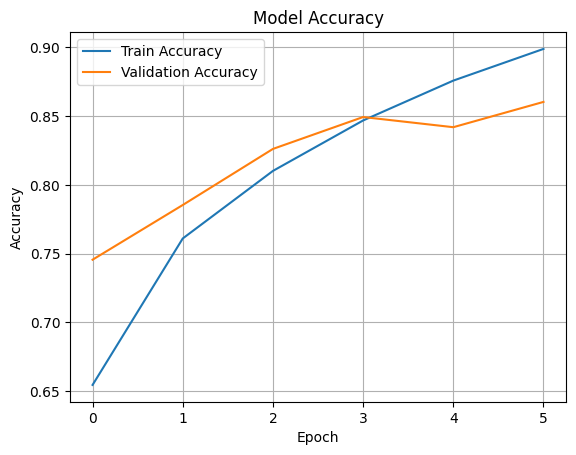

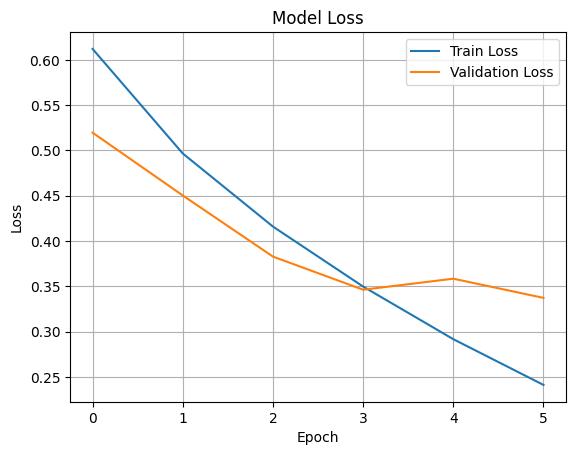

In [65]:
#plotting results
# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


| Observation                  | Interpretation                              |
| ---------------------------- | ------------------------------------------- |
| Good convergence             | Model is successfully learning key patterns |
| Early overfitting            | Might benefit from **regularization**       |
| Training continues improving | But generalization stops improving          |


In [66]:
#Saving the model
model.save("cats_vs_dogs_cnn_model.h5")


Testing the Model

In [67]:
# Extract test1.zip into a new folder
test_zip = "data/test1.zip"
test_extract_path = "data/test_images"

with zipfile.ZipFile(test_zip, 'r') as zip_ref:
    zip_ref.extractall(test_extract_path)

print("Test images extracted.")


Test images extracted.


In [68]:
test_folder = "data/test_images/test1"  # correct path to actual images
test_files = glob.glob(f"{test_folder}/*.jpg")

print(f"Found {len(test_files)} test images.")


Found 12500 test images.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


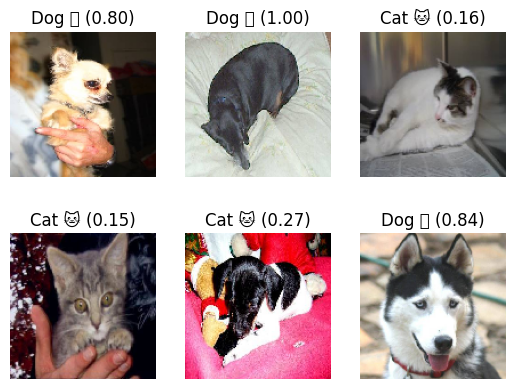

In [69]:
for i, img_path in enumerate(test_files[:6]):
    img = image.load_img(img_path, target_size=(128, 128))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)[0][0]
    label = "Dog 🐶" if prediction > 0.5 else "Cat 🐱"

    plt.subplot(2, 3, i+1)
    plt.imshow(img)
    plt.title(f"{label} ({prediction:.2f})")
    plt.axis("off")


| Step               | Description                              |
| ------------------ | ---------------------------------------- |
| `image.load_img()` | Loads a single image and resizes it      |
| `img_to_array()`   | Converts to NumPy array                  |
| `model.predict()`  | Outputs a probability: closer to 1 = dog |
| `plt.imshow()`     | Visualizes predictions with labels       |


Monte Carlo for Uncertainity

In [70]:
# Custom wrapper to enable dropout at inference
def predict_with_uncertainty(f_model, X, n_iter=50):
    # Get dropout output tensor
    f_output = K.function([f_model.input, K.learning_phase()], [f_model.output])

    predictions = np.array([
        f_output([X, 1])[0] for _ in range(n_iter)  # `1` keeps dropout ON
    ])

    prediction_mean = predictions.mean()
    prediction_std = predictions.std()
    return prediction_mean, prediction_std


In [71]:
# This model will manually force training=True to keep dropout ON
class MCDropoutModel(Model):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def call(self, inputs, training=False):
        return self.model(inputs, training=True)  # <- force dropout ON


In [72]:
# Wrap your trained model
mc_model = MCDropoutModel(model)

# Predict multiple times
def predict_with_uncertainty_tf2(mc_model, X, n_iter=50):
    preds = [mc_model(X, training=True).numpy()[0][0] for _ in range(n_iter)]
    return np.mean(preds), np.std(preds)


In [73]:
# Use the updated test_files list
img_path = test_files[0]  # e.g., data/test_images/test1/1.jpg
img = image.load_img(img_path, target_size=(128, 128))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Run MC Dropout-based prediction
mean_pred, std_pred = predict_with_uncertainty_tf2(mc_model, img_array, n_iter=50)
label = "Dog" if mean_pred > 0.5 else "Cat"

print(f"🧠 Prediction: {label} ({mean_pred:.2f}) ± {std_pred:.2f}")


🧠 Prediction: Dog (0.77) ± 0.14


In [74]:

results = []

# Loop through first 20 test images
for img_path in test_files[:20]:
    try:
        # Load and preprocess
        img = image.load_img(img_path, target_size=(128, 128))
        img_array = image.img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        # Get prediction and uncertainty
        mean_pred, std_pred = predict_with_uncertainty_tf2(mc_model, img_array, n_iter=50)
        label = "Dog" if mean_pred > 0.5 else "Cat"

        # Store results
        results.append({
            "path": img_path,
            "mean": mean_pred,
            "std": std_pred,
            "label": label
        })
    except Exception as e:
        print(f"Error processing {img_path}: {e}")


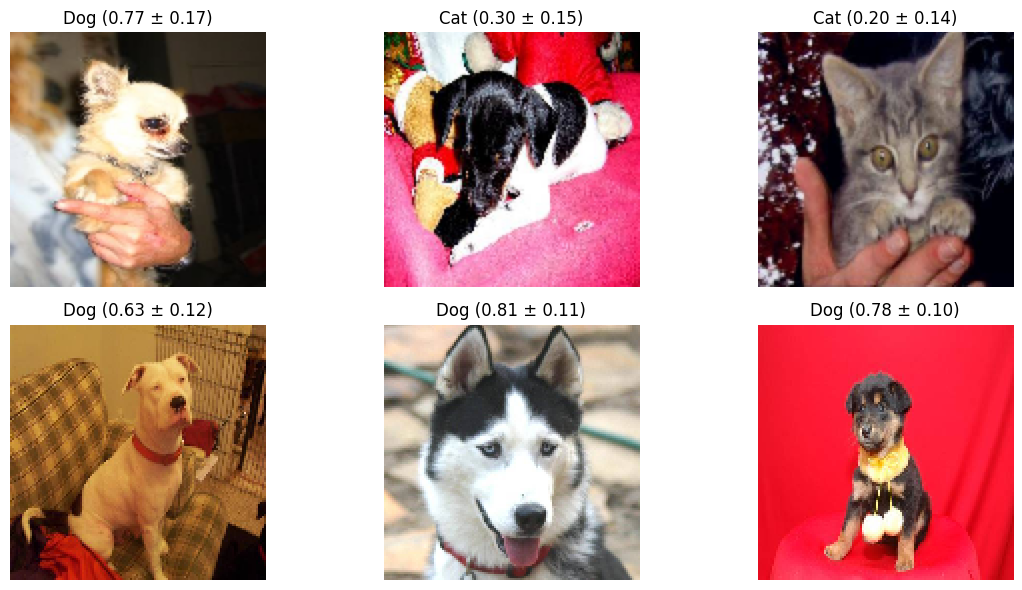

In [75]:
# Sort by uncertainty (highest std)
results_sorted = sorted(results, key=lambda x: -x["std"])

# Plot top 6 most uncertain
plt.figure(figsize=(12, 6))
for i in range(6):
    img = image.load_img(results_sorted[i]["path"], target_size=(128, 128))

    plt.subplot(2, 3, i+1)
    plt.imshow(img)
    plt.title(f"{results_sorted[i]['label']} ({results_sorted[i]['mean']:.2f} ± {results_sorted[i]['std']:.2f})")
    plt.axis("off")

plt.tight_layout()
plt.show()
